# Dimensionality Reduction: Alternative decompositions of your data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import ipyvolume.pylab as p3
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from IPython.display import YouTubeVideo

In [2]:
pca = PCA()

mpl.rcParams.update({'font.size':16})

# A function for plotting 3-dimensional data
def plot3d(df):
    data = df.values
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(*data[:,0:3].T)
    minn,maxx = data.min(),data.max()
    ax.set_xlim(minn,maxx)
    ax.set_ylim(minn,maxx)
    ax.set_zlim(minn,maxx)
    ax.set_xlabel(df.columns[0],labelpad=10)
    ax.set_ylabel(df.columns[1],labelpad=10)
    ax.set_zlabel(df.columns[2],labelpad=10)
    ax.dist = 12
    plt.tight_layout()
    
def plot3d_live(data):
    fig = p3.figure()
    q = p3.scatter(*data.T, size=1, marker="sphere")
    p3.style.use("dark") # looks better
    p3.show()
        
# A function for summarizing covariancs and correlations
def summarize(info,name,quiet=False):
    values = info[name]
    if not quiet:
        print(values.round(2))
    plt.pcolor(values,cmap='RdBu_r',vmin=-values.max(),vmax=values.max())
    raynge = np.arange(values.shape[0])
    if not quiet:
        plt.xticks(raynge+0.5,raynge)
        plt.yticks(raynge+0.5,raynge)
    else:
        plt.xticks([])
        plt.yticks([])
    plt.gca().invert_yaxis() # Make y-axis go from low to high like a matrix
    plt.colorbar().set_label(name)
    if not quiet:
        eigenvalues,_ = np.linalg.eig(info[name])
        for i,eig in enumerate(sorted(eigenvalues,reverse=True)):
            print('Eigenvalue #%d is %.3g' % (i+1,eig))
        
def report_mean_var(data):
    for i in range(data.shape[1]):
        column = data[:,i]
        print("Dimension %d has mean %.2g and variance %.3g" % \
              (i+1,column.mean(),column.var()))
        
def annotate_scatter(ax,df):
    for i, text in enumerate(df.index):
        ax.text(df['PC 1'].iloc[i],df['PC 2'].iloc[i], text)
        
def variance_explained(df,pca):
    #pca.fit(df.values)
    n_components = min(*df.shape)
    if pca.n_components:
        n_components = min(n_components,pca.n_components)
    for i in range(n_components):
        print("PC %d explains %.3g%% of the variance" % (i+1,100*pca.explained_variance_ratio_[i]))
        
def pc_report(pca,df):
    #pca.fit(df.values)
    n_components = min(*df.shape)
    if pca.n_components:
        n_components = min(n_components,pca.n_components)
    pca_df = pd.DataFrame(pca.components_.T,
                          index=df.columns,
                          columns=['PC %d' % (i+1) for i in range(n_components)])
    return pca_df

def plot_transformed_data(pca,df,figsize=None):
    #pca.fit(df.values)
    n_components = min(*df.shape)
    if pca.n_components:
        n_components = min(n_components,pca.n_components)
    pca_df = pd.DataFrame(pca.transform(df.values),
                      index=df.index,
                      columns=['PC %d' % (i+1) for i in range(n_components)])
    ax = pca_df.plot.scatter('PC 1','PC 2',figsize=figsize)
    annotate_scatter(ax,pca_df)

my_fake_data = np.random.rand(100,3)
my_fake_data[:,2] = (my_fake_data[:,0] + my_fake_data[:,1])/np.sqrt(2)

## Problem 1: when new dimensions are combinations of dozens of old dimensions, they are hard to interpret.  

In [3]:
# From the Allen Brain Institute
df = pd.read_csv('data/rnaseq_donor9861/RNAseqTPM.csv',header=None,index_col=0)
df.index.name = 'gene'
df = df.loc[df.sum(axis=1)>0] # Only keep genes expressed in the brain
annotation = pd.read_csv('data/rnaseq_donor9861/SampleAnnot.csv')
df.columns = annotation['sub_structure']
df = df.div(df.std())
df = df.iloc[:1000] # First 1000 genes
df.head()

sub_structure,SPL,SPL,SPL,AnG-s,SFG-l,OrbGyri,GRe,OrbGyri,OrbGyri,GRe,...,CbCx,CbCx,CbCx,CbCx,Caudate,Putamen,Putamen,GP,GP,Caudate
gene,,,,,,,,,,,,,,,,,,,,,
A1BG,0.011194,0.010637,0.006680,0.006624,0.014408,0.011485,0.012184,0.008673,0.005452,0.011517,...,0.016367,0.019517,0.025355,0.021652,0.008597,0.004800,0.014561,0.008946,0.011106,0.005852
A1BG-AS1,0.018332,0.016154,0.010716,0.008684,0.015934,0.004627,0.015811,0.009567,0.006772,0.009150,...,0.036212,0.024954,0.035871,0.031312,0.003170,0.002717,0.002133,0.001423,0.000625,0.001036
A1CF,0.000126,0.000079,0.000165,0.000034,0.000187,0.000077,0.000036,0.000000,0.000000,0.000062,...,0.000778,0.000598,0.000680,0.000749,0.000058,0.000000,0.000023,0.000063,0.000010,0.000022
A2LD1,0.003853,0.006276,0.004937,0.003001,0.005220,0.004913,0.005040,0.002486,0.002257,0.003414,...,0.008609,0.006781,0.007862,0.004426,0.002740,0.002169,0.003489,0.003922,0.002082,0.002789
A2M,0.151248,0.180798,0.154388,0.065665,0.239243,0.183631,0.168100,0.201794,0.203660,0.173383,...,0.285683,0.357846,0.271383,0.313836,0.191314,0.122652,0.150343,0.170788,0.104944,0.178982


In [4]:
pca = PCA(n_components=3).fit(df.T.values)
pc_report(pca,df.T).head()

,PC 1,PC 2,PC 3
gene,,,
A1BG,-0.000489,0.000507,0.001313
A1BG-AS1,-0.001043,0.000817,-0.000199
A1CF,-0.000011,0.000039,-0.000011
A2LD1,-0.000115,0.000150,0.000149
A2M,-0.004028,0.004772,-0.003601


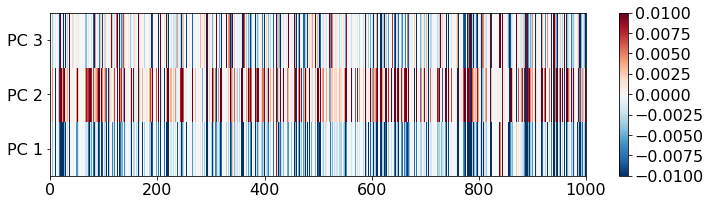

In [5]:
plt.figure(figsize=(12,3))
plt.pcolor(pca.components_,vmin=-0.01,vmax=0.01,cmap='RdBu_r')
plt.yticks(np.arange(3)+0.5,['PC %d' % (i+1) for i in range(3)])
plt.colorbar();

## Solution: force each new dimensions to utilize only a few old dimensions

In [6]:
from sklearn.decomposition import SparsePCA
sparse_pca = SparsePCA(alpha=2,n_components=3).fit(df.T.values)
pc_report(sparse_pca,df.T).head()

,PC 1,PC 2,PC 3
gene,,,
A1BG,0.000000,0.0,0.0
A1BG-AS1,0.000000,0.0,0.0
A1CF,0.000000,0.0,0.0
A2LD1,0.000000,0.0,0.0
A2M,-0.108026,0.0,0.0


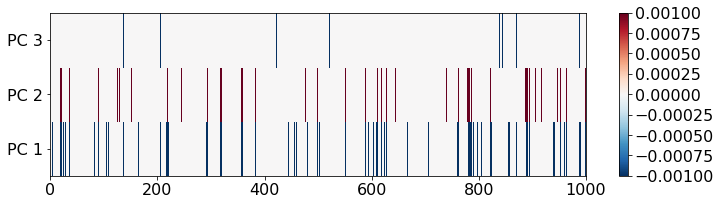

In [7]:
plt.figure(figsize=(12,3))
plt.pcolor(sparse_pca.components_,vmin=-0.001,vmax=0.001,cmap='RdBu_r')
plt.yticks(np.arange(3)+0.5,['PC %d' % (i+1) for i in range(3)])
plt.colorbar();

In [8]:
pcs = pc_report(sparse_pca,df.T)
list(pcs[pcs['PC 3']!=0].index.values) # List the genes that contribute to PC3

['ACBD7',
 'ACTB',
 'ACTG1',
 'AGT',
 'AGXT2L1',
 'AHCYL1',
 'AIF1L',
 'ALDH2',
 'ALDH4A1',
 'ALDOC',
 'ANKRD40',
 'ANXA5',
 'APLP1',
 'APOC1',
 'APOD',
 'APOE',
 'AQP4',
 'ARL2']

## Problem 2: when negative values don't make any sense

## Solution: use a non-negative decomposition

In [9]:
from sklearn.decomposition import NMF

![pca-faces](https://archive.cnx.org/resources/28b7669c052b1d7ec07962bb69aa5cc3733eb868/PCA_Face.png)

![nmf-faces](https://archive.cnx.org/resources/86d95a5d66974426fb30f0ab24d91bd901dbbc83/NMF_Face.png)

![odors](http://journals.plos.org/plosone/article/figure/image?size=large&id=10.1371/journal.pone.0073289.g006)

## Problem #3: My data values are all relative to each other!

In [10]:
raw_df = pd.read_csv('data/capdist.csv').set_index(['ida','idb'])
europe = ['GFR','BEL','BUL','DEN','EST','FIN','FRN','GRC','IRE','ITA','LAT','LIT',
          'LUX','MLT','NTH','AUS','POL','POR','RUM','SWD','SLO','SLV','SPN','CZE',
          'HUN','UK','CYP','CRO']
df = pd.DataFrame(index=europe,columns=europe)
for country1 in europe:
    for country2 in europe:
        if country1==country2:
            df.loc[country1,country2] = 0
        else:
            df.loc[country1,country2] = raw_df.loc[(country1,country2),'kmdist']
df.head() # My data is the distances (in kilometers) between each country in Europe

,GFR,BEL,BUL,DEN,EST,FIN,FRN,GRC,IRE,ITA,...,RUM,SWD,SLO,SLV,SPN,CZE,HUN,UK,CYP,CRO
GFR,0,202,1526,662,1498,1568,415,1872,988,1085,...,1581,1213,763,707,1398,523,943,506,2694,862
BEL,202,0,1707,781,1635,1697,266,2036,806,1190,...,1776,1323,961,880,1278,725,1139,313,2876,1034
BUL,1526,1707,0,1645,1890,1997,1771,453,2511,893,...,317,1921,819,829,2264,1114,644,2020,1169,679
DEN,662,781,1645,0,856,916,1044,2074,1245,1554,...,1567,552,847,1017,2052,577,1004,935,2741,1137
EST,1498,1635,1890,856,0,108,1896,2340,2015,2165,...,1672,381,1320,1601,2896,1196,1382,1780,2745,1658


## Solution: use multi-dimensional scaling

In [11]:
from sklearn.manifold.mds import MDS
mds = MDS(dissimilarity='precomputed').fit(df.values)
mds_df = pd.DataFrame(mds.embedding_,index=europe,columns=['PC 1','PC 2'])
mds_df.head()

,PC 1,PC 2
GFR,-29.891617,-502.101987
BEL,-91.471113,-694.460662
BUL,-294.946182,999.922559
DEN,618.280121,-368.690332
EST,1352.649511,72.054874


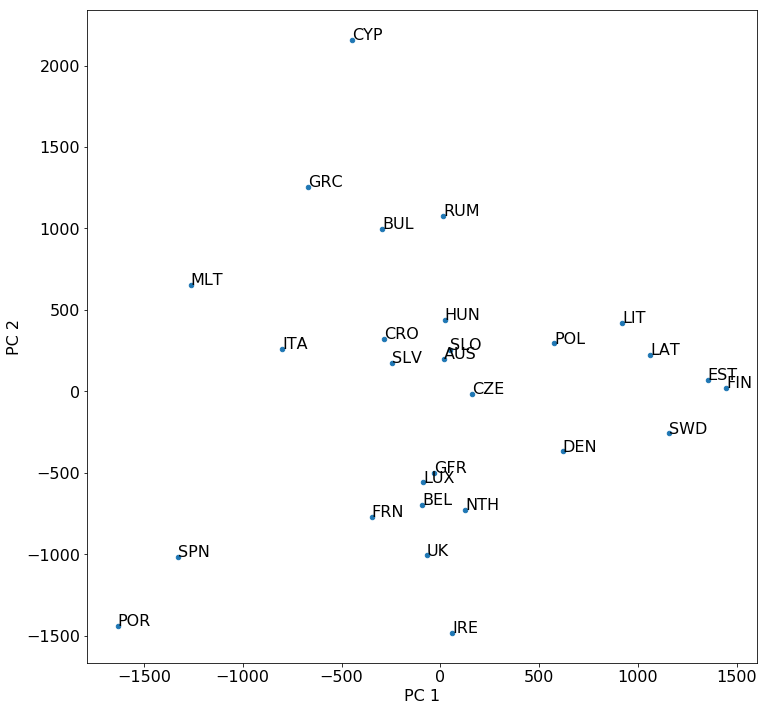

In [12]:
ax = mds_df.plot.scatter(x='PC 1',y='PC 2',figsize=(12,12))
annotate_scatter(ax,mds_df)